In [1]:
import numpy as np
import scipy as scp

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import pandas as pd

import sys

import warnings

import ipywidgets as widgets

import warnings

import multiprocessing
from multiprocessing import Pool
from functools import partial

import h5py
import pickle

"""
check python version
"""
import platform
     
print(platform.python_version())

"""
make anaconda available
"""
import sys


"""
create environmental variable "MKL_THREADING_LAYER"
"""
import os
os.environ["MKL_THREADING_LAYER"] = "GNU"


"""
check theano version and config file
"""
import theano
#print(theano.__version__)
#print(theano.config)


"""
import  Delfi package
"""
sys.path.append('/gpfs01/berens/user/cschroeder/Documents/Ribbon_PR_project/delfi')
import delfi
import delfi.distribution as dd
from delfi.inference import SNPE
from delfi.simulator.BaseSimulator import BaseSimulator
from delfi.summarystats import Identity
from delfi.generator import Default
from delfi.generator.BaseGenerator import BaseGenerator

#from delfi.distribution import MixedDistribution
from delfi import kernel
from delfi.kernel.BaseKernel import BaseKernel
from delfi.summarystats.BaseSummaryStats import BaseSummaryStats



3.8.0


Can not use cuDNN on context None: cannot compile with cuDNN. We got this error:
b'In file included from /tmp/try_flags_e4qr60lc.c:4:0:\n/usr/include/cudnn.h:56:10: fatal error: cuda_runtime.h: No such file or directory\n #include <cuda_runtime.h>\n          ^~~~~~~~~~~~~~~~\ncompilation terminated.\n'
Mapped name None to device cuda: NVIDIA GeForce RTX 2080 Ti (0000:2F:00.0)


In [2]:
delfi.__version__

'0.5.1'

### load data

In [3]:
# load data

# open file
f = h5py.File("data_reextracted.hdf5", "r")

wave_normal = np.array(f['wave_control'])
wave_blocked = np.array(f['wave_blocked'])
wavelength = np.array(f['wavelength'])
opsins = np.array(f['opsins'])

for item in f.attrs:
    print(item, f.attrs[item])

f.close()

wave_blocked_raw = np.copy(wave_blocked)
wave_control_raw = np.copy(wave_normal)
opsins_raw = np.copy(opsins)

# normalizing
for i in range(4):
    wave_blocked[i] = wave_blocked[i] - np.min(wave_blocked[i])
    wave_blocked[i] = wave_blocked[i] / np.max(abs(wave_blocked[i]))
    
    wave_normal[i] = wave_normal[i] / np.max(abs(wave_normal[i]))
    
    opsins[i] =  opsins[i] - np.max(opsins[i])
    opsins[i] =  opsins[i] / np.min(opsins[i])


    
"""
load model
"""

from hc_model import run_model_hc
from hc_model import extract_params
from hc_model import get_param_labels

from parallel_running import run_model_x
# specify modes
modes = [['HC0', 'HC1', 'HC2'],
 ['HC0', 'HC1'],
 ['HC0', 'HC2'],
 ['HC1', 'HC2'],
 ['HC0'],
 ['HC1'],
 ['HC2'],
 'special']

# number of params per mode
mode_params = [12,9,8,7,5,4,3,13]


info: cone signals under normal and rescaled conditions. In order R,G,B,UV, aligned to wavelength axis. Same for opsins.


In [4]:
"""
!!!! model output is 4x296 !!!
"""
'''
def run_model_x(params, o, mode, N=200):
    """
    helper to extract parameters
    and set params 0 if negative
    """
    
    w,dc,a = extract_params(params,mode)
    
    # set to 0 if negative
    w[w<0] = 0 
    dc[dc<0] = 0 
    a[a<0] = 0 
    
    
    k_fit = run_model_hc(o,w,dc,a,N=N)
    
    return k_fit #, baseline_store
'''

"""
own generator class
"""
class myGenerator(BaseGenerator):
    def __init__(self, *args, gen_minibatch, **kwargs):
        super().__init__(*args, **kwargs)
        self.gen_minibatch = gen_minibatch

    def gen(self, *args, **kwargs):
        if 'minibatch' in kwargs:
            minibatch = kwargs.pop('minibatch')
        else:
            minibatch = self.gen_minibatch
        return super().gen(*args, minibatch=minibatch, **kwargs)


"""
Define simulator class
"""
class HC_Class(BaseSimulator):
    def __init__(self, simulator, opsins, mode, dim=1, seed=None):
        """
        Model of HC cone interaction in zebrafish
        Parameters
        ----------
        
        seed : int or None
            If set, randomness is seeded
        """
        super().__init__(dim_param=dim, seed=seed)
        self.opsins = opsins
        self.simulate1 = simulator 
        self.mode = mode
        
        
    def gen_single(self, params):
        """
        run one simulation of the model
        ------
        params : 1 dim array
        """        
        params = np.asarray(params).reshape(-1)
        assert params.ndim == 1
        assert params.shape[0] == self.dim_param


        sample = self.simulate1( params, self.opsins, self.mode)

        return {'data': sample.reshape(-1)}

    def run_parallel(self, *params):
        """
        runs simNormalized in a for loop, with n = len(params)
        to be used in multiprocessing - starmap
        """
        #print(len(params))
        result = []
        for i in range(0,len(params)):
            result_single = self.simulate1(params[i], self.opsins, self.mode)
            result.append({'data':result_single.reshape(-1)})
        return result
    
    '''    
    # from base class
    def gen(self, params_list, n_reps=1, pbar=None):
        """Forward model for simulator for list of parameters
        Parameters
        ----------
        params_list : list of lists or 1-d np.arrays
            List of parameter vectors, each of which will be simulated
        n_reps : int
            If greater than 1, generate multiple samples given param
        pbar : tqdm.tqdm or None
            If None, will do nothing. Otherwise it will call pbar.update(1)
            after each sample.
        Returns
        -------
        data_list : list of lists containing n_reps dicts with data
            Repetitions are runs with the same parameter set, different
            repetitions. Each dictionary must contain a key data that contains
            the results of the forward run. Additional entries can be present.
        """
        data_list = []
        for param in params_list:
            rep_list = []
            for r in range(n_reps):
                rep_list.append(self.gen_single(param))
            data_list.append(rep_list)
            if pbar is not None:
                pbar.update(1)

        return data_list
    '''
        

    
    
    # adapted gen for parallel processing
    # n_reps > 1 not yet implemented!!!
    def gen(self, params_list, n_reps=1, pbar=None, verbose = False, skip_feedback=False, prior_mixin=0,
            minibatch=100, keep_data=True, from_prior=False,):
        """Forward model for simulator for list of parameters
        Parameters
        ----------
        params_list : list of lists or 1-d np.arrays
            List of parameter vectors, each of which will be simulated
        n_reps : int
            If greater than 1, generate multiple samples given param
                TODO: not yet implemented in parallel run!!!
        pbar : tqdm.tqdm or None
            If None, will do nothing. Otherwise it will call pbar.update(1)
            after each sample.
        Returns
        -------
        data_list : list of lists containing n_reps dicts with data
            Repetitions are runs with the same parameter set, different
            repetitions. Each dictionary must contain a key data that contains
            the results of the forward run. Additional entries can be present.
        """
        # specify used cpus (should be intelligently chosen to minibatchsize)
        pr = 41 # 26
        
        # calc runs per cpu (last cpu is left for remainder of division)
        singlejobs = round(np.shape(params_list)[0]/(pr-1))
        
        # reshape params_list
        fitparams = list([])
        for i in range(0,pr-1):
            fitparams.append(params_list[i*singlejobs:(i+1)*singlejobs])
        fitparams.append(params_list[(i+1)*singlejobs:])
        # runs parallel the simulations
        with multiprocessing.Pool(processes=pr) as pool:
            JexoMult = pool.starmap(self.run_parallel, fitparams)
        
        
        
        # reshape the simulated data
        data_list = []
        for i in range(np.shape(JexoMult)[0]):
            for j in range(np.shape(JexoMult[i])[0]):
                rep_list = []
                rep_list.append(JexoMult[i][j])
                data_list.append(rep_list)
                if pbar is not None:
                    pbar.update(1)
                
        return data_list

    
"""
create summary statistics
"""
def mse(fit, data):
    """
    compute sqrt(mse)!!!
    """
    #mse = 1/(np.shape(data)[0]*np.shape(data)[1]) * np.sum((data - fit)**2)
    mse = 1/(len(data)) * np.sum((data - fit)**2)
    #if mse >20:
    #    mse = 100
    if np.isnan(mse):
        #raise Warning('mse is Nan. Check your model.')
        return 10e3
    else:
        return min(np.sqrt(mse), 10e3)

class MseSS(BaseSummaryStats):
    """
    Reduces data to mse
    """

    def __init__(self, data, seed=None):
        super().__init__(seed=seed)
        # should return a matrix n_samples x 1 (mse)
        self.n_summary = 1
        self.data = data

    @copy_ancestor_docstring
    def calc(self, repetition_list):
        # See BaseSummaryStats.py for docstring

        # get the number of repetitions contained
        n_reps = len(repetition_list)

        # build a matrix of n_reps x 1
        repetition_stats_matrix = np.zeros((n_reps, self.n_summary))

        # for every repetition, take the mean of the data in the dict
        for rep_idx, rep_dict in enumerate(repetition_list):
            repetition_stats_matrix[rep_idx, ] = mse(rep_dict['data'], self.data)

        return repetition_stats_matrix

    
class DELFI_HC():
    def  __init__(self, opsins, mode,  nparams, recorded_data):
        self.opsins = opsins
        self.mode = mode
        self.nparams = nparams
        self.recorded_data = recorded_data
    
    def initialize_model(self, prior):
        """initialize model"""
            
        # define prior
        if prior =='gauss':
            mean_start = np.ones(self.nparams)#*0.5
            self.prior = dd.Gaussian(m = mean_start , S=np.eye(self.nparams)*0.03)
            
        elif prior == 'uniform':
            self.prior = dd.Uniform(lower= np.zeros(nparams), upper= np.ones(nparams)*3)
        else:
            raise NameError('This prior is not yet implemented.')
        
        
        # initialize summary statistics 
        self.s = MseSS(self.recorded_data) 
        
        # initialize model
        self.m = HC_Class(run_model_x, self.opsins, self.mode, dim=self.nparams)
        self.generator = myGenerator(model= self.m, prior= self.prior, summary=self.s, gen_minibatch=1000) 
        #BaseGenerator(model= self.m, prior= self.prior, summary=self.s)
     
        
        
        
        
        ##########################################################################################
        
    def infer_params(self, rounds, n_train, x0 = None,
                     save=True, filename = None, 
                     bw=1, q=None):

        """
        run the inference algorithme in mulitple rounds
        ---
        params:
        : rounds:    number of rounds
        : nr_train:  number of samples per round (int or list of int) [100000, 10000]
        : bw:        bandwidht of Gauss-kernel
        """
        folderpath = 'SNPE_data/'
        
        # raise error if no filename is specified
        if save:
            if filename == None:
                raise NameError('No filename for saving specified.')
                
            filelist = os.listdir(folderpath)
            
            if filename in filelist:
                raise NameError('Filename already exists.')
        
        # observed data 
        xo = x0 #np.array([x0])

        starttime = datetime.datetime.now()
        print('Starting time for inference:', starttime)

        # set kernel
        kernel = delfi.kernel.HalfGauss(xo)#, bandwidth=bw) #delfi.kernel.Gauss(xo, bandwidth=bw)
        
        # initialize
        inf_snpe = SNPE(generator=self.generator,
                        prior_mixin=0, # mix additional N*prior_mixin samples into samples from proposal prior
                        n_components=3, 
                        n_hiddens=[40,40], 
                        obs=xo,
                        pseudo_obs_perc= 0.5, 
                        pseudo_obs_n= None,
                        kernel_bandwidth_perc=30,
                        kernel_bandwidth_n= None,
                        kernel_bandwidth_min=0.05,
                        pseudo_obs_use_all_data= False,
                        pilot_samples=None, 
                        kernel=kernel, 
                        svi=False,
                        reg_lambda=0.01, # precision parameter in svi, default 0.01
                        impute_missing=True,
                        init_trn_data_folder= mode,#'flashtds',
                        verbose=True) 
        
        #if changing_obs:
        #    if not len(x0)==rounds:
        #        raise NameError('length of x0  does not match the number of rounds.')
                
        
        # returning loss of DNN, (params, simulations), posteriors (for each round)
        logs, tds, posteriors = inf_snpe.run(n_train=n_train, 
                                             n_rounds=rounds, 
                                             proposal = self.prior, 
                                             epochs= 800,#800, 
                                             minibatch= 500, #500 
                                             stop_on_nan=True,
                                             monitor= None,  #{'missing':missing}, ????
                                             save_trn_data=True,
                                             load_trn_data= True,
                                             append_trn_data=True,
                                             init_tds_file='test',
                                             round_cl=3) #init_trn_data_folder= 'flashtds_decay_singlerise_D1',
        

        runtime = datetime.datetime.now() - starttime
        print('Runtime: ',runtime, ' in total' )
        print()


        if save:
            """
            saving the posteriors
            """
            filepath = folderpath+filename
            info = '{} rounds, n_train = {} , SNPE, n_components=3, n_hiddens=[80,80],obs={}, \
                    pilot_samples=None, 1000 epochs, minibatch=500, uniform prior,prior_mixin=0, bandwidth={}, svi=False\
                    kernel=gauss,SS=MSE, runtime: {:.5} min'.format(rounds, samples,x0,bw, runtime.total_seconds()/60)
            #print(info)
            
            saveobject = dict({'posterior': posteriors, 
                               'logs':logs,
                               'SNPE_info': info,
                              'tds':tds})
            pickle.dump( saveobject, open(filepath, "wb" ) )

        return logs, tds, posteriors, inf_snpe
    
    
    
    
def get_posts(SNPE_model, tds, percentile, verbose=False, return_x0=False, nround=-1):
    """
    returns posterior evaluated q_phi(theta|x0), where x0 = percentile(MSE)
    """

    x0 = np.percentile( tds[nround][1] [np.invert(np.isnan(tds[nround][1]))] , percentile)
    
    if verbose:
        print('q_phi(theta|x0) evaluated at x0=', x0)
    
    post = SNPE_model.predict(np.array([[x0]]))
    if return_x0:
        return post, x0

    return postlist

In [5]:
"""
loading the posteriors of one mode


filenames = ['full_4_with_CL.pkl',
             'mode1_0.pkl',
            'mode2_0.pkl',
            'mode3_0.pkl',
            'mode4_0.pkl',
            'mode5_0.pkl',
            'mode6_0.pkl',]

"""



 # load object
folderpath = '/gpfs01/berens/user/cschroeder/Documents/Biophysical Models/Cone_HC_interaction/Delfi/fit_results/v2/'
filename =  'mode0_0.pkl'#'full_4_with_CL.pkl' #'mode_specialH0full_0.pkl'
filepath = folderpath+filename

with open(filepath, "rb") as f:
    load_object = pickle.load(f)
    posteriors = load_object['posterior']
    logs = load_object['logs']
    tds = load_object['tds']
    inf_snpe = load_object['model']
    info = load_object['SNPE_info']
    mode = load_object['mode']

print('loaded mode:', mode)
print(info)


loaded mode: ['HC0', 'HC1', 'HC2']
5 rounds, n_train = 200000 , SNPE, n_components=3, n_hiddens=[100,100],obs=[[0]], 0.01pseudo_obs             pilot_samples=None, 600 epochs, minibatch=500, gauss prior,prior_mixin=0, bandwidth=20p, svi=False            kernel=gauss,SS=MSE, runtime: 96.375 min. prior=1,eye*0.25 


In [6]:
for nround in range(5):
    print('round',nround, np.sum(tds[nround][1]<0.13))

round 0 0
round 1 340
round 2 8594
round 3 7938
round 4 13491


In [7]:
%%time
"""
whole pipeline for:
(depending on options)
- extract info from posterior
- sampling
- simulations

- uncorrelated sampling and simulation 
"""
from parallel_running import runparallelsamples

save = True

return_H_in = True

# number of samples/evaluations
n = 100000

# choose option

sampling = True

simulate = True

uncorrelated_sampling_simulation = False



# initialize dict to store 
data_dict = {}

"""
loading the posteriors of all modes
"""

filenames = ['mode0_0.pkl', 
             'mode1_0.pkl',
            'mode2_0.pkl',
            'mode3_0.pkl',
            'mode4_0.pkl',
            'mode5_0.pkl',
            'mode6_0.pkl',
            'mode7_0.pkl',]

posterior_criterion = ['number',
                      'number',
                      'number',
                      'number',
                      'number',
                      'number', # percentile
                      'number', 
                      'number'] # percentile

# for modex_0
# which_posterior = [2,4,4,5,2, 0.001, 0.001]

# for modex_1
#old: which_posterior = [3,4,4,2,4,4,3]
#new: 
which_posterior = [4,3,4,3,2,1,4,4 ]


for i in range(0,8):
     # load object
    folderpath = '/gpfs01/berens/user/cschroeder/Documents/Biophysical Models/Cone_HC_interaction/Delfi/fit_results/v2/'
    filename =  filenames[i]
    filepath = folderpath+filename
    print()
    print()
    print('opening:', filename)

    with open(filepath, "rb") as f:
        load_object = pickle.load(f)
        posteriors = load_object['posterior']
        logs = load_object['logs']
        tds = load_object['tds']
        inf_snpe = load_object['model']
        info = load_object['SNPE_info']
        mode = load_object['mode']
    print('loaded mode:', mode)
    print(info)
    
    """
    choose posterior
    """
    if posterior_criterion[i]=='number':
        post_new = posteriors[which_posterior[i]]
    elif posterior_criterion[i]=='percentile':
        post_new, x0_new = get_posts(inf_snpe, tds, which_posterior[i], verbose=True, return_x0=True, nround=-1)
    else:
        raise Warning('no posterior loaded')
    
    print()

    """
    extract info from posterior
    """
    covs = []
    mus = []
    a = post_new.a


    for j in range(3):
        covs.append(post_new.xs[j].S)
        mus.append(post_new.xs[j].m)

    mus=np.array(mus)
    covs = np.array(covs)
    mu_proj = post_new.project_to_gaussian().m
    cov_proj = post_new.project_to_gaussian().S

    # insert this to data dict
    data_dict[i]= {'mode' : mode,
                    'a' : a,
                    'mus' : mus,
                    'covs' : covs,
                    'mu_proj' : mu_proj,
                    'cov_proj' : cov_proj}
    
    
    if sampling:
        print('sampling...')
        """
        sample from posterior
        """
        random_samples = post_new.gen(n)

        # insert to data_dict
        data_dict[i]['samples'] = random_samples
        
        
    if simulate:
        # specify number of CPUs to use
        p = Pool(40)

        print('running simulations...')
        results = p.map(partial(runparallelsamples, 
                                wave_blocked=wave_blocked, 
                                mode=mode, 
                                wave_normal=wave_normal,
                               return_H_in=return_H_in),
                        random_samples)

        """
        unravel
        """
        random_eva = np.zeros((n, 4,np.shape(results[0][0])[1]))
        random_loss = np.zeros(n)
        
        random_H_in = np.zeros((n, 3,np.shape(results[0][0])[1]))


        for j in range(n):
            random_eva[j] = results[j][0]
            random_loss[j] = results[j][1]
            if return_H_in:
                random_H_in[j] = results[j][2]
            
        # insert to data_dict
        data_dict[i]['evaluations'] = random_eva
        data_dict[i]['loss'] = random_loss
        if return_H_in:
            data_dict[i]['H_in'] = random_H_in

            
    """
    uncorrelated sampling and simulation
    """

    if uncorrelated_sampling_simulation:
        #construct uncorrelated samples (cov = diag(cov))
        print('sampling from uncorrelated components')
        p_uncorr = delfi.distribution.mixture.GaussianMixture.MoG(a=a,
                                                          ms=mus, 
                                                          Ss=[np.eye(len(mus[0]))*np.diag(covs[0]),
                                                            np.eye(len(mus[0]))*np.diag(covs[1]),
                                                            np.eye(len(mus[0]))*np.diag(covs[2])])
        
        uncorrelated_samples = p_uncorr.gen(n)

        # insert to data_dict
        data_dict[i]['uncorrelated_samples'] = uncorrelated_samples
        
        
        """
        run simulations
        """
        # specify number of CPUs to use
        p = Pool(40)

        print('running uncorrelated simulations...')
        results = p.map(partial(runparallelsamples, 
                                wave_blocked=wave_blocked, 
                                mode=mode, 
                                wave_normal=wave_normal,
                               return_H_in=return_H_in),
                        uncorrelated_samples)

        
        #unravel
        random_eva = np.zeros((n, 4,np.shape(results[0][0])[1]))
        random_loss = np.zeros(n)

        for j in range(n):
            random_eva[j] = results[j][0]
            random_loss[j] = results[j][1]
            
        # insert to data_dict
        data_dict[i]['evaluations_uncorrelated'] = random_eva
        data_dict[i]['loss_uncorrelated'] = random_loss
    
    
print('Finished')  


data_dict['info'] = 'posteriors chosen from criterion...'

filename = 'simulations_posteriors_0.pkl'
folderpath = 'fit_results/v2'
filelist = os.listdir(folderpath)

if save:
    if filename in filelist:
        raise NameError('Filename already exists.')

    else:
        with open(folderpath+'/'+filename, "wb") as f:
            pickle.dump(data_dict, f)
        print('saved.')



opening: mode0_0.pkl
loaded mode: ['HC0', 'HC1', 'HC2']
5 rounds, n_train = 200000 , SNPE, n_components=3, n_hiddens=[100,100],obs=[[0]], 0.01pseudo_obs             pilot_samples=None, 600 epochs, minibatch=500, gauss prior,prior_mixin=0, bandwidth=20p, svi=False            kernel=gauss,SS=MSE, runtime: 96.375 min. prior=1,eye*0.25 

sampling...
running simulations...


opening: mode1_0.pkl
loaded mode: ['HC0', 'HC1']
5 rounds, n_train = 200000 , SNPE, n_components=3, n_hiddens=[100,100],obs=[[0]], 0.01pseudo_obs             pilot_samples=None, 600 epochs, minibatch=500, gauss prior,prior_mixin=0, bandwidth=20p, svi=False            kernel=gauss,SS=MSE, runtime: 102.6 min. prior=1,eye*0.25 

sampling...
running simulations...


opening: mode2_0.pkl
loaded mode: ['HC0', 'HC2']
5 rounds, n_train = 200000 , SNPE, n_components=3, n_hiddens=[100,100],obs=[[0]], 0.01pseudo_obs             pilot_samples=None, 600 epochs, minibatch=500, gauss prior,prior_mixin=0, bandwidth=20p, svi=False    

14.09 starting mode 0, <1min for sampling

14.11 starting mode 1, <1 min for sampling

14.13 starting mode 2,  <1 min for sampling

In [20]:
"""
compute percentiles etc.

FOR ORIGINAL SAMPLES

and append to saved file 
"""
def compute_perc_mean(loss_all, ps, loss_noHC = 0.327282196924212):
    """
    ps: 3 percentiles to compute f.ex.: [25,50,75]
    """

    loss_mean = []
    loss_std = []
    accepted_sims = []
    loss_percentiles = np.zeros((8,3))
    for i in range(8):
        loss_mean.append(np.mean(loss_all[i][loss_all[i]<loss_noHC]))
        loss_std.append(np.std(loss_all[i][loss_all[i]<loss_noHC]))
        accepted_sims.append(np.sum(loss_all[i]<loss_noHC))
        loss_percentiles[i][0] = np.percentile(loss_all[i],ps[0])
        loss_percentiles[i][1] = np.percentile(loss_all[i],ps[1])
        loss_percentiles[i][2] = np.percentile(loss_all[i],ps[2])
    
    return loss_mean, loss_std, accepted_sims, loss_percentiles


# load losses of correct posteriors
filename = 'simulations_posteriors_0.pkl'
folderpath = 'fit_results/v2'
with open(folderpath+'/'+filename, "rb") as f:
    dictname = pickle.load(f)

loss_all = []
#loss_uncorrelated_all = []
for i in range(8):
    loss_all.append(dictname[i]['loss'])
    #loss_uncorrelated_all.append(dictname[i]['loss_uncorrelated'])
    
loss_all = np.array(loss_all)
#loss_uncorrelated_all = np.array(loss_uncorrelated_all)



# compute percentiles etc.

loss_mean, loss_std, accepted_sims, loss_percentiles_25_75 = compute_perc_mean(loss_all, ps=[25,50,75])
loss_mean, loss_std, accepted_sims, loss_percentiles_5_95 = compute_perc_mean(loss_all, ps=[5,50,95])

#loss_uncorrelated_mean, loss_uncorrelated_std, accepted_sims_uncorrelated, loss_percentiles_uncorrelated = compute_perc_mean(loss_uncorrelated_all)


# append everything to dict
dictname['loss_mean'] = loss_mean
dictname['loss_std'] = loss_std
dictname['accepted_sims'] = accepted_sims
dictname['loss_percentiles_25_75'] = loss_percentiles_25_75
dictname['loss_percentiles_5_95'] = loss_percentiles_5_95


#dictname['loss_uncorrelated_mean'] = loss_uncorrelated_mean
#dictname['loss_uncorrelated_std'] = loss_uncorrelated_std
#dictname['accepted_sims_uncorrelated'] = accepted_sims_uncorrelated
#dictname['loss_percentiles_uncorrelated'] = loss_percentiles_uncorrelated

# save 
with open(folderpath+'/'+filename, "wb") as f:
    pickle.dump(dictname, f)


In [5]:
"""
compute percentiles etc.

FOR UNCORRELATED SAMPLES

and append to saved file 
"""

# load losses of correct posteriors
filename = 'simulations_posteriors_uncorrelated_v2.pkl'
folderpath = 'fit_results'
with open(folderpath+'/'+filename, "rb") as f:
    dictname = pickle.load(f)

#loss_all = []
loss_uncorrelated_all = []
for i in range(7):
    #loss_all.append(dictname[i]['loss'])
    loss_uncorrelated_all.append(dictname[i]['loss_uncorrelated'])
    
#loss_all = np.array(loss_all)
loss_uncorrelated_all = np.array(loss_uncorrelated_all)



#loss_mean, loss_std, accepted_sims, loss_percentiles = compute_perc_mean(loss_all)

loss_uncorrelated_mean, loss_uncorrelated_std, accepted_sims_uncorrelated, loss_percentiles_uncorrelated_25_75 = compute_perc_mean(loss_uncorrelated_all, 
                                                                                                                                   ps=[25,50,95])
loss_uncorrelated_mean, loss_uncorrelated_std, accepted_sims_uncorrelated, loss_percentiles_uncorrelated_5_95 = compute_perc_mean(loss_uncorrelated_all,
                                                                                                                                  ps=[25,50,95])



# append everything to dict
#dictname['loss_mean'] = loss_mean
#dictname['loss_std'] = loss_std
#dictname['accepted_sims'] = accepted_sims
#dictname['loss_percentiles'] = loss_percentiles

dictname['loss_uncorrelated_mean'] = loss_uncorrelated_mean
dictname['loss_uncorrelated_std'] = loss_uncorrelated_std
dictname['accepted_sims_uncorrelated'] = accepted_sims_uncorrelated
dictname['loss_percentiles_uncorrelated_25_75'] = loss_percentiles_uncorrelated_25_75
dictname['loss_percentiles_uncorrelated_5_95'] = loss_percentiles_uncorrelated_5_95


# save 
with open(folderpath+'/'+filename, "wb") as f:
    pickle.dump(dictname, f)


No handles with labels found to put in legend.


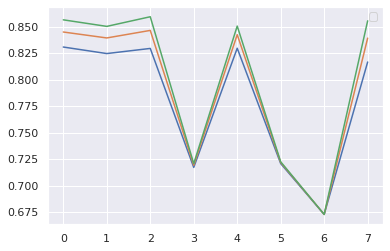

In [21]:
plt.plot(1-loss_percentiles_25_75[:,2])
plt.plot(1-loss_percentiles_25_75[:,1])
plt.plot(1-loss_percentiles_25_75[:,0])

#plt.plot(1-loss_percentiles0[:,1])
#plt.plot(1-loss_percentiles_uncorrelated[:,2], label='uncorrelated_samples')
plt.legend()

## get best parameters

In [22]:
"""
get best params over all runs
"""
def get_best_params(tds, return_minima=False, verbose=False):
    """
    get best params out of tds list
    return array of minima, if True

    """

    minima = np.zeros((len(tds)))

    for nround in range(len(tds)):
        minima[nround] = np.nanmin(tds[nround][1])

    # best index
    ind = np.unravel_index(np.nanargmin(minima, axis=None), minima.shape)

    nround = ind[0]
    bestparams = tds[nround][0][np.nanargmin(tds[nround][1])]

    if verbose:
        print('smallest loss:', minima)
    if return_minima:
        return bestparams, minima

    else:
        return bestparams

In [23]:
"""
get best parameters from SNPE fit
"""
best_params_dict={}

"""
loading the posteriors of all modes

# with same arguments as above
"""


for i in range(0,8):
     # load object
    folderpath = '/gpfs01/berens/user/cschroeder/Documents/Biophysical Models/Cone_HC_interaction/Delfi/fit_results/v2/'
    filename =  filenames[i]
    filepath = folderpath+filename
    print()
    print()
    print('opening:', filename)

    with open(filepath, "rb") as f:
        load_object = pickle.load(f)
        posteriors = load_object['posterior']
        logs = load_object['logs']
        tds = load_object['tds']
        inf_snpe = load_object['model']
        info = load_object['SNPE_info']
        mode = load_object['mode']
    print('loaded mode:', mode)
    print(info)
    
    """
    choose posterior
    """
    if posterior_criterion[i]=='number':
        post_new = posteriors[which_posterior[i]]
    elif posterior_criterion[i]=='percentile':
        post_new, x0_new = get_posts(inf_snpe, tds, which_posterior[i], verbose=True, return_x0=True, nround=-1)
    else:
        raise Warning('no posterior loaded')
    
    print()





    best_params, best_loss_all = get_best_params(tds, return_minima=True, verbose=True)
    best_loss = np.min(best_loss_all)
    
    best_params_dict[i] = {'params_0': best_params,
                          'loss_0': best_loss}



opening: mode0_0.pkl
loaded mode: ['HC0', 'HC1', 'HC2']
5 rounds, n_train = 200000 , SNPE, n_components=3, n_hiddens=[100,100],obs=[[0]], 0.01pseudo_obs             pilot_samples=None, 600 epochs, minibatch=500, gauss prior,prior_mixin=0, bandwidth=20p, svi=False            kernel=gauss,SS=MSE, runtime: 96.375 min. prior=1,eye*0.25 

smallest loss: [0.1353881  0.11030684 0.09337331 0.10059131 0.0904327 ]


opening: mode1_0.pkl
loaded mode: ['HC0', 'HC1']
5 rounds, n_train = 200000 , SNPE, n_components=3, n_hiddens=[100,100],obs=[[0]], 0.01pseudo_obs             pilot_samples=None, 600 epochs, minibatch=500, gauss prior,prior_mixin=0, bandwidth=20p, svi=False            kernel=gauss,SS=MSE, runtime: 102.6 min. prior=1,eye*0.25 

smallest loss: [0.14090672 0.11454784 0.10809976 0.1122509  0.10598494]


opening: mode2_0.pkl
loaded mode: ['HC0', 'HC2']
5 rounds, n_train = 200000 , SNPE, n_components=3, n_hiddens=[100,100],obs=[[0]], 0.01pseudo_obs             pilot_samples=None, 600 epoc

In [24]:
"""
append best parameters from sampling
"""
for i in range(8):
    
    loss = np.min(data_dict[i]['loss'])
    
    if loss < best_params_dict[i]['loss_0']:
        params = data_dict[i]['samples'][np.argmin(data_dict[i]['loss'])]
        best_params_dict[i]['sampling'] = {'params': params,
                              'loss': loss}

In [25]:
best_params_dict

{0: {'params_0': array([ 0.77960207,  1.50815095,  0.58999491,  0.15657358,  2.29812179,
          1.24537931, -1.32842322,  3.02619474,  0.32443147,  2.31385086,
          1.38791226,  0.44364034]),
  'loss_0': 0.09043270327216314},
 1: {'params_0': array([ 0.4833589 ,  1.96672331,  1.07039585, -0.53880394, -0.65107354,
          1.37092265,  0.09479944,  2.952673  ,  0.71692418]),
  'loss_0': 0.10598493857365797},
 2: {'params_0': array([0.60780255, 2.30868673, 1.23428343, 0.08556535, 1.41474867,
         0.17580181, 2.46472911, 0.96330643]),
  'loss_0': 0.10418015681488481},
 3: {'params_0': array([ 2.38051577e+00,  8.71257245e-01, -4.47066788e-04,  2.18681726e+00,
         -2.47824812e-01,  2.58565627e+00,  3.58048201e-01]),
  'loss_0': 0.1499859446322234},
 4: {'params_0': array([ 0.87055695,  2.20298865,  0.95424039, -0.00692129,  1.70642127]),
  'loss_0': 0.12840581625725964},
 5: {'params_0': array([ 1.64870113, -1.36594429, -0.42755496,  3.20788286]),
  'loss_0': 0.18320363339

In [26]:
modes

[['HC0', 'HC1', 'HC2'],
 ['HC0', 'HC1'],
 ['HC0', 'HC2'],
 ['HC1', 'HC2'],
 ['HC0'],
 ['HC1'],
 ['HC2'],
 'special']

In [27]:
"""
save best params
"""

filename = 'bestparams.pkl'
folderpath = 'fit_results/v2'
filelist = os.listdir(folderpath)
            
if filename in filelist:
    raise NameError('Filename already exists.')

else:
    with open(folderpath+'/'+filename, "wb") as f:
        pickle.dump(best_params_dict, f)
    

In [16]:

#dictname = {modenr: best_params}
filename = 'bestparams.pkl'
folderpath = 'fit_results/v2'
with open(folderpath+'/'+filename, "rb") as f:
    dictname = pickle.load(f)
    #dictname[modenr]= best_params
    #pickle.dump(dictname, f)

In [17]:
dictname

{'mode1': [array([ 0.4914053 ,  2.82836276,  1.43904746, -0.02067508,  0.93689447,
          0.03600872,  2.2380482 ,  1.36359693]), 0.08877011217790515],
 'mode2': [array([ 0.4372995 ,  2.41718718,  1.33170165,  0.95748624, -0.63858667,
          2.58658873,  1.2467624 ]), 0.08947205780582365],
 'mode3': [array([ 2.78397838,  1.39444316,  0.44631404,  1.3621571 , -0.33863958,
          2.16675029,  1.50512792]), 0.13317768635712673],
 'mode4': [array([0.73453284, 1.89059492, 0.811868  , 1.98874023]),
  0.12827917726020802],
 'mode5': [array([1.21503982, 1.38577384, 0.36762149, 1.38323773]),
  0.2770037705488892],
 'mode6': [array([ 1.71944544, -0.40845356,  3.04967445]), 0.3040370470682795],
 'modeS': [array([ 0.81065317,  2.08612365,  0.89543405, -0.36345541,  1.80224496]),
  0.12827964135591785],
 'mode0': [array([0.26727893, 1.92871563, 0.96795228, 0.66289271, 0.64211844,
         0.96731133, 1.16284766, 0.01523152, 3.13809119, 0.43962869,
         1.09536613]), 0.08650600729110917